In [136]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy as sp
import random

In [2]:
BATCH_SIZE = 64
SEED = 278839

In [128]:
train_set = np.load("kmnist-train-imgs.npz")["arr_0"]
train_labels = np.load("kmnist-train-labels.npz")["arr_0"]

test_set = np.load("kmnist-test-imgs.npz")["arr_0"]
test_labels = np.load("kmnist-test-labels.npz")["arr_0"]

length = len(np.unique(train_labels))

train_labels = to_categorical(train_labels, length)
test_labels = to_categorical(test_labels, length)

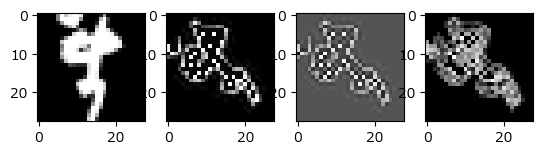

In [172]:
img1 = train_set[15]
img2 = sp.ndimage.rotate(img1, angle=45, reshape=False)
blur = sp.ndimage.gaussian_filter(img2, 0.1)
blur2 = sp.ndimage.gaussian_filter(blur, 0.3)
alpha = 5
sh = blur + alpha * (blur - blur2)
d = sp.ndimage.spline_filter(sh, order=2)
z = sp.ndimage.gaussian_gradient_magnitude(img2, 0.3)
plt.subplot(1, 4, 1)
plt.imshow(img1, cmap="gray")
plt.subplot(1, 4, 2)
plt.imshow(sh, cmap="gray")
plt.subplot(1, 4, 3)
plt.imshow(d, cmap="gray")
plt.subplot(1, 4, 4)
plt.imshow(z, cmap="gray")

In [ ]:
augmentedTrainData = []
augmentedTestData = []
random.seed(SEED)
for image in test_set:
    rotatedImage = sp.ndimage.rotate(image, angle=random.randint(0, 360), reshape=False)
    augmentedImage = sp.ndimage.gaussian_gradient_magnitude(rotatedImage, 0.3)
    augmentedTestData.append(augmentedImage)

for image in train_set:
    rotatedImage = sp.ndimage.rotate(image, angle=random.randint(0, 360), reshape=False)
    augmentedImage = sp.ndimage.gaussian_gradient_magnitude(rotatedImage, 0.3)
    augmentedTrainData.append(augmentedImage)

aTestData = np.array(augmentedTestData)
# a1Test = {"arr_0": aTestData}
# np.savez('a3/a3Test.npz', **a1Test)

aTrainData = np.array(augmentedTrainData)
# a1Train = {"arr_0": aTrainData}
# np.savez('a3/a3Train.npz', **a1Train)

In [165]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1), padding="same"))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(length, activation="softmax", kernel_regularizer='l2'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 flatten_3 (Flatten)         (None, 6400)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [162]:
history = model.fit(train_set, train_labels, epochs=4, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/4
938/938 [==============================] - 32s 34ms/step - loss: 1.3971 - accuracy: 0.5240
Epoch 2/4
938/938 [==============================] - 34s 36ms/step - loss: 0.8780 - accuracy: 0.7111
Epoch 3/4
938/938 [==============================] - 36s 38ms/step - loss: 0.7037 - accuracy: 0.7683
Epoch 4/4
938/938 [==============================] - 36s 39ms/step - loss: 0.5937 - accuracy: 0.8026


In [166]:
history = model.fit(aTrainData, train_labels, epochs=4, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/4
938/938 [==============================] - 36s 37ms/step - loss: 1.9584 - accuracy: 0.2708
Epoch 2/4
938/938 [==============================] - 35s 38ms/step - loss: 1.6525 - accuracy: 0.3816
Epoch 3/4
938/938 [==============================] - 36s 38ms/step - loss: 1.4701 - accuracy: 0.4509
Epoch 4/4
938/938 [==============================] - 35s 38ms/step - loss: 1.3067 - accuracy: 0.5270


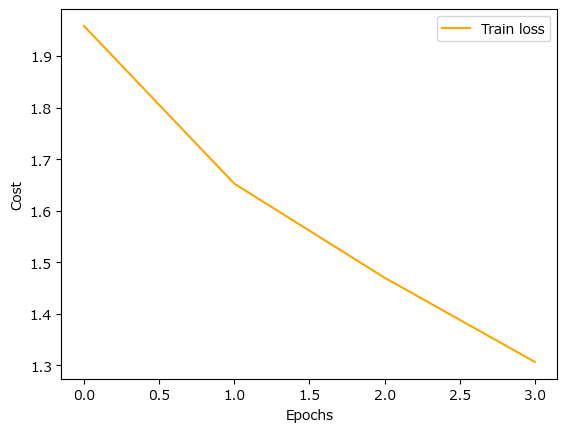

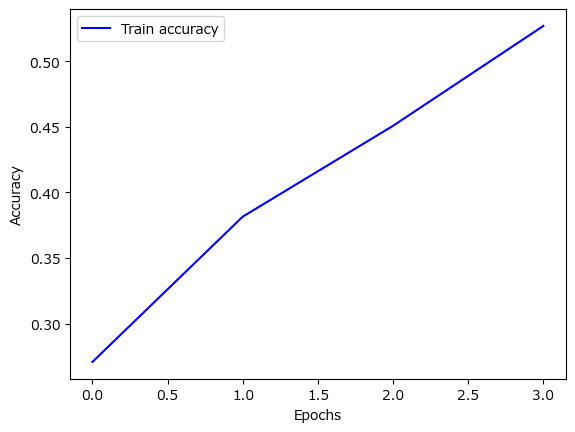

In [167]:
plt.plot(history.history['loss'], label='Train loss', color='orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

plt.plot(history.history['accuracy'], label='Train accuracy', color='blue')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [168]:
history.history

print("Evaluate model on test data")
results = model.evaluate(test_set, test_labels, batch_size=BATCH_SIZE)
print("test loss, test accuracy:", results)

print("Prediction")
prediction = model.predict(test_set)
conMatrix = confusion_matrix(test_labels.argmax(axis=1), prediction.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=conMatrix, display_labels="おきすつなはまやれを")
plt.rcParams['font.family'] = 'Meiryo'
disp.plot(cmap=plt.cm.Blues)
plt.show()

Evaluate model on test data
157/157 [==============================] - 2s 9ms/step - loss: 34.0383 - accuracy: 0.3236
test loss, test accuracy: [34.03832244873047, 0.32359999418258667]
Prediction


KeyboardInterrupt: 

Evaluate model on test data
157/157 [==============================] - 1s 9ms/step - loss: 1.3060 - accuracy: 0.5709
test loss, test accuracy: [1.305987000465393, 0.570900022983551]
Prediction
313/313 [==============================] - 2s 5ms/step


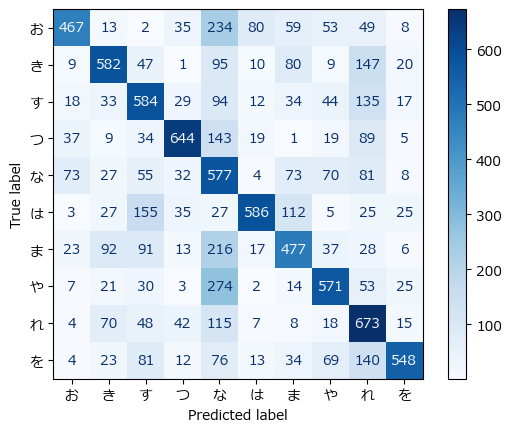

In [169]:
history.history

print("Evaluate model on test data")
results = model.evaluate(aTestData, test_labels, batch_size=BATCH_SIZE)
print("test loss, test accuracy:", results)

print("Prediction")
prediction = model.predict(aTestData)
conMatrix = confusion_matrix(test_labels.argmax(axis=1), prediction.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=conMatrix, display_labels="おきすつなはまやれを")
plt.rcParams['font.family'] = 'Meiryo'
disp.plot(cmap=plt.cm.Blues)
plt.show()